<h1> Implementation of Variational autoencoders </h1>
<p> This is program can be trained on both GPU as well as CPU. </p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from scipy.stats import norm
%matplotlib inline

In [22]:
#######Just downloading the whole dataset and also creating batches

train_transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

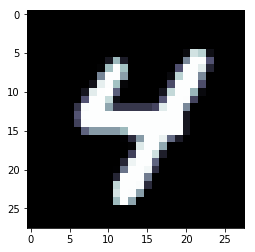

In [100]:
######## Just checking out what the dataset looks like

dataiter = iter(trainloader)
images, labels = dataiter.next()

images.shape
plt.imshow(images[32].squeeze().numpy(), cmap='bone')

## Defining of various important functions and also the architecture of the model

In [33]:
########Definition of the architecture of our encoder and decoder model with all the assisting functions

class Net(nn.Module):
    def __init__(self, num_latent):
        super().__init__()
        
        #So here we will first define layers for encoder network
        self.encoder = nn.Sequential(nn.Conv2d(1, 3, 3, padding=1),
                                     nn.AvgPool2d(2, 2),
                                     nn.BatchNorm2d(3),
                                     nn.Conv2d(3, 16, 3, padding=1),
                                     nn.AvgPool2d(2, 2),
                                     nn.BatchNorm2d(16),
                                     nn.Conv2d(16, 16, 3, padding=1))
        
        #These two layers are for getting logvar and mean
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.mean = nn.Linear(128, num_latent)
        self.var = nn.Linear(128, num_latent)
        
        #######The decoder part
        #This is the first layer for the decoder part
        self.expand = nn.Linear(num_latent, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 784)
        self.decoder = nn.Sequential(nn.ConvTranspose2d(16, 16, 3, padding=1),
                                     nn.BatchNorm2d(16),
                                     nn.ConvTranspose2d(16, 3, 8),
                                     nn.BatchNorm2d(3),
                                     nn.ConvTranspose2d(3, 1, 15))
        
    def enc_func(self, x):
        #here we will be returning the logvar(log variance) and mean of our network
        x = self.encoder(x)
        x = x.view([-1, 784])
        x = F.dropout2d(self.fc1(x), 0.5)
        x = self.fc2(x)
        
        mean = self.mean(x)
        logvar = self.var(x)
        return mean, logvar
    
    def dec_func(self, z):
        #here z is the latent variable state
        z = self.expand(z)
        z = F.dropout2d(self.fc3(z), 0.5)
        z = self.fc4(z)
        z = z.view([-1, 16, 7, 7])
        
        out = self.decoder(z)
        out = F.sigmoid(out)
        return out
    
    def get_hidden(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)   #So as to get std
            noise = torch.randn_like(mean)   #So as to get the noise of standard distribution
            return noise.mul(std).add_(mean)
        else:
            return mean
    
    def forward(self, x):
        mean, logvar = self.enc_func(x)
        z = self.get_hidden(mean, logvar)
        out = self.dec_func(z)
        return out, mean, logvar

In [34]:
#######This is the custom loss function defined for VAE
### You can even refere to: https://github.com/pytorch/examples/pull/226 

def VAE_loss(out, target, mean, logvar):
    category1 = nn.BCELoss()
    bce_loss = category1(out, target)
    
    #We will scale the following losses with this factor
    scaling_factor = out.shape[0]*out.shape[1]*out.shape[2]*out.shape[3]
    
    ####Now we are gonna define the KL divergence loss
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar))
    kl_loss /= scaling_factor
    
    return bce_loss + kl_loss

In [35]:
######The function which we will call for training our model

def train(trainloader, iters, model, device, optimizer, print_every):
    counter = 0
    for i in range(iters):
        model.train()
        model.to(device)
        for images, _ in trainloader:
            images = images.to(device)
            optimizer.zero_grad()
            out, mean, logvar = model(images)
            loss = VAE_loss(out, images, mean, logvar)
            loss.backward()
            optimizer.step()
            
        if(counter % print_every == 0):
            model.eval()
            n = 10  # figure with 20x20 digits
            digit_size = 28
            figure = np.zeros((digit_size * n, digit_size * n))

            # Construct grid of latent variable values
            grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
            grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

            counter = 0
            # decode for each square in the grid
            for i, yi in enumerate(grid_x):
                for j, xi in enumerate(grid_y):
                    digit = out[counter].squeeze().cpu().detach().numpy()
                    figure[i * digit_size: (i + 1) * digit_size,
                           j * digit_size: (j + 1) * digit_size] = digit
                    counter += 1

            plt.figure(figsize=(10, 10))
            plt.imshow(figure, cmap='bone')
            plt.show()  

        counter += 1
                    

## The training process
Here you can tweak the parameters and see different results altogether

/home/aniket/.conda/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1101: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


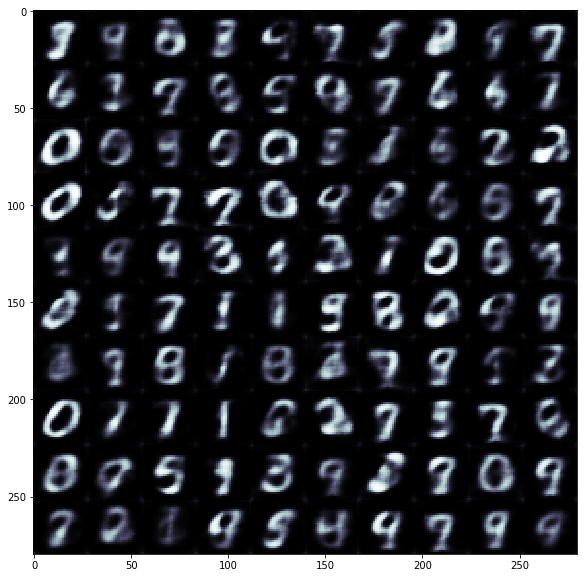

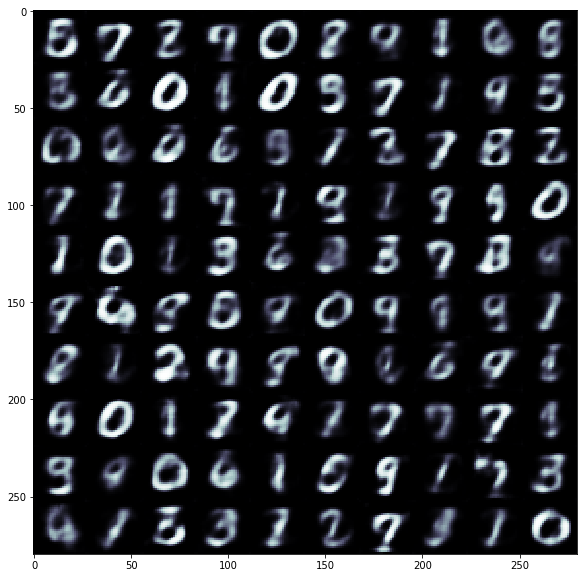

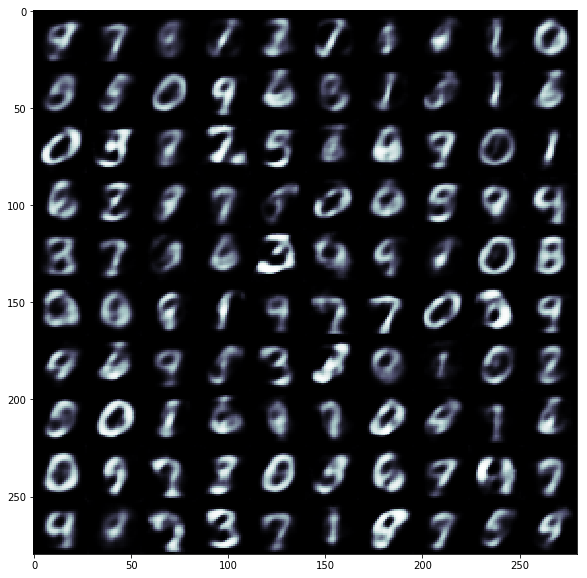

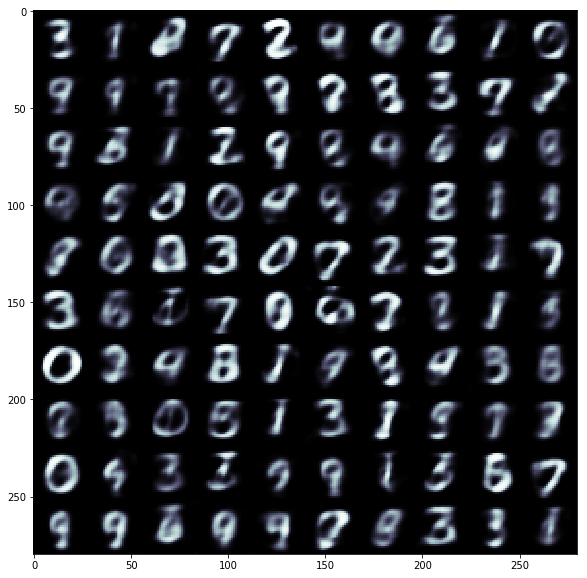

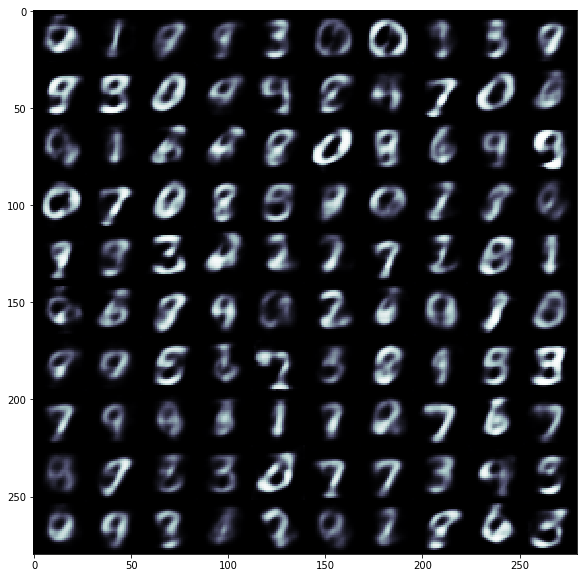

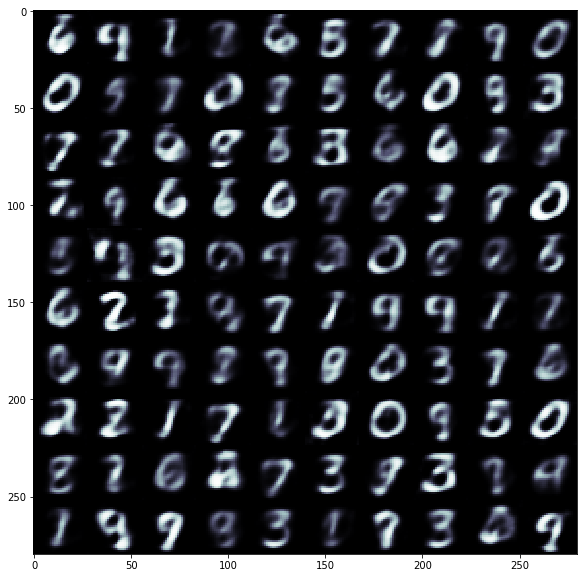

In [36]:
######Setting all the hyperparameters
##You can change them if you want

iters = 26
num_latent = 8
print_every = 5    #print after every 5 iterations
model = Net(num_latent)

device = ('cuda' if torch.cuda.is_available() else 'cpu')
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(trainloader, iters, model, device, optimizer, print_every)

## Here we will be seeing images and then the reconstruction by the model

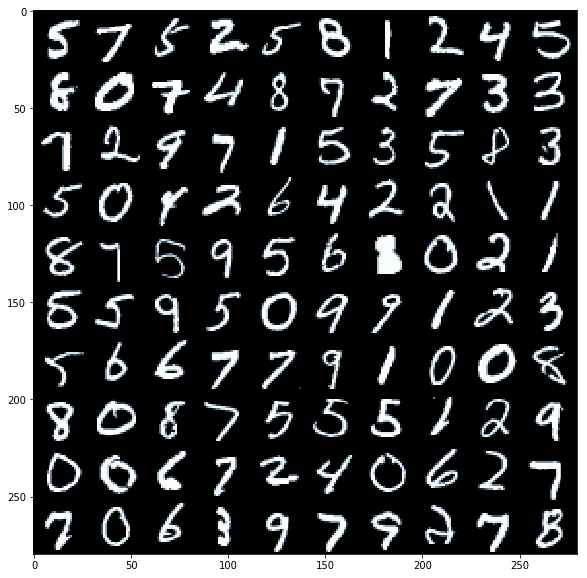

In [37]:
from scipy.stats import norm

dataiter = iter(trainloader)
images, labels = dataiter.next()

# Display a 2D manifold of the digits
n = 10  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

counter = 0
# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        digit = images[counter].squeeze()
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        counter += 1

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='bone')
plt.show()  

/home/aniket/.conda/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1101: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


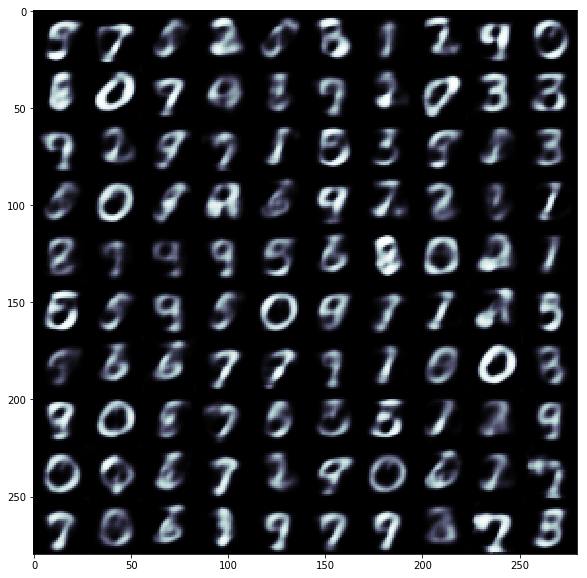

In [38]:
model.to('cpu')
model.eval()
out, _, _ = model(images)

# Display a 2D manifold of the digits
n = 10  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

counter = 0
# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        digit = out[counter].squeeze().detach().numpy()
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        counter += 1

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='bone')
plt.show()  

## Here we will be testing the model by just passing in some random values

/home/aniket/.conda/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:1101: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


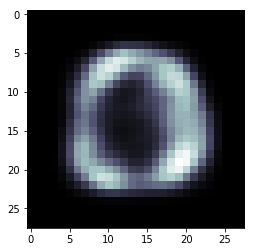

In [99]:
#########
##In this cell you we can test around with some random values from the normal distribution and see some of the
##random images by the model
#########

rand_z = torch.randn([1, 8])
out = model.dec_func(rand_z)
plt.imshow(out.squeeze().detach().numpy(), cmap='bone')

## Now here we will be trying to visualize the latent state by first applying t-sne on it

In [138]:
######This cell is for the visualization part of the latent state of the model

from sklearn.manifold import TSNE

#Here I have just created one more trainloader which can help me out in the displaying of the images
trainloader_new = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)
dataiter = iter(trainloader_new)
images, labels = dataiter.next()

mean, logvar  = model.enc_func(images)
z = model.get_hidden(mean, logvar)

#Since my latent state consists of 8 dimensions, I must first reduce it to 2 dimensions so as to be able to
#visualize them
z_embedded = TSNE(n_components=2).fit_transform(z.detach().numpy())

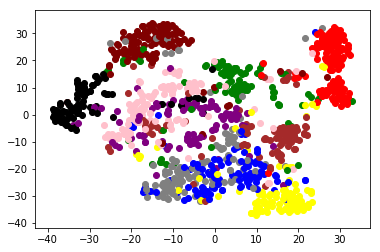

In [152]:
for i in range(1000):
    if(labels[i].numpy() == 0):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='black')
    elif(labels[i].numpy() == 1):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='red')
    elif(labels[i].numpy() == 2):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='green')
    elif(labels[i].numpy() == 3):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='pink')
    elif(labels[i].numpy() == 4):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='gray')
    elif(labels[i].numpy() == 5):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='purple')
    elif(labels[i].numpy() == 6):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='maroon')
    elif(labels[i].numpy() == 7):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='yellow')
    elif(labels[i].numpy() == 8):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='brown')
    elif(labels[i].numpy() == 9):
        plt.scatter(z_embedded[i, 0], z_embedded[i, 1], c='blue')
        
    plt.plot()

**As we can clearly see in the above graph there is a clear distinction between the latent states of different states indicating that the model has learned well**